### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import seaborn as sns
import scipy.stats as stats
import datetime as dt

### Prep

In [2]:
#read in tables
countiesdf = pd.read_csv('./data/county.csv', index_col = 0)
pricesdf = pd.read_csv('./data/price.csv', index_col = 0)
productsdf = pd.read_csv('./data/product.csv', index_col = 0)
storesdf = pd.read_csv('./data/store.csv', index_col = 0)
vendorsdf = pd.read_csv('./data/vendor.csv', index_col = 0)
categoriesdf = pd.read_csv('./data/category.csv', index_col = 0)
transactionsdf = pd.read_csv('./data/transaction.csv', index_col = 0)

C:\Users\dougl\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
#creates lists of college towns and zip codes
college_towns = ['Ames', 'Iowa City', 'Waterloo', 'Cedar Falls', 'Waterloo-Cedar Falls']
college_zips = [50010, 50011, 50012, 50013, 50014, 52240, 52242, 52243, 52244, 52245, 
                52246, 50701, 50702, 50703, 50704, 50707, 50613, 50614]

##### Checking and converting data types

In [4]:
countiesdf.head()

,CountyNumber,County
0,68,Monroe
1,17,Cerro Gordo
2,1,Adair
3,85,Story
4,21,Clay


In [5]:
#checks data types in countiesdf
print(countiesdf.dtypes)

CountyNumber     int64
County          object
dtype: object


In [6]:
pricesdf.head()

,ItemNumber,StateBottleCost,StateBottleRetail,Date
28783,42723,7.49,11.24,2018-01-02
30030,54448,11.29,16.94,2018-01-02
26935,22151,12.45,18.68,2018-01-02
28770,34546,7.00,10.50,2018-01-02
26937,43316,11.99,17.99,2018-01-02


In [7]:
#checks data types in pricesdf
print(pricesdf.dtypes)

ItemNumber             int64
StateBottleCost      float64
StateBottleRetail    float64
Date                  object
dtype: object


In [8]:
#convert date column to date type
pricesdf['Date'] = pd.to_datetime(pricesdf['Date'], infer_datetime_format=True)

In [9]:
#checks that date column is now date type
print(pricesdf.dtypes)

ItemNumber                    int64
StateBottleCost             float64
StateBottleRetail           float64
Date                 datetime64[ns]
dtype: object


In [10]:
productsdf.head()

,ItemNumber,ItemDescription,Pack,BottleVolume(ml)
0,36308,Hawkeye Vodka,6,1750
1,45888,Sailor Jerry Spiced Navy Rum,6,1750
2,55084,Paramount Blackberry Brandy,24,375
3,67557,Kamora Coffee Liqueur,12,1000
4,77487,Tortilla Gold Dss,12,1000


In [11]:
#checks data types in productsdf
print(productsdf.dtypes)

ItemNumber           int64
ItemDescription     object
Pack                 int64
BottleVolume(ml)     int64
dtype: object


In [12]:
storesdf.head()

,StoreNumber,StoreName,City,ZipCode,CountyNumber,Date
24166,5224,Keystone Liquor & Wine / Coralville,Coralville,52241.0,52,2018-01-02
24130,4872,Casey's General Store #2644 / Earlham,Earlham,50072.0,61,2018-01-02
21828,5254,Discount Liquor,Cedar Rapids,52402.0,57,2018-01-02
23760,4485,DYNO'S 51 / SANBORN,Sanborn,51248.0,71,2018-01-02
24246,4900,Kwik Stop 4 / Waterloo,Waterloo,50703.0,7,2018-01-02


In [13]:
#checks data types in storesdf
print(storesdf.dtypes)

StoreNumber       int64
StoreName        object
City             object
ZipCode         float64
CountyNumber      int64
Date             object
dtype: object


In [14]:
#convert date column to date type
storesdf['Date'] = pd.to_datetime(storesdf['Date'], infer_datetime_format=True)

In [15]:
#checks that date column is now date type
print(storesdf.dtypes)

StoreNumber              int64
StoreName               object
City                    object
ZipCode                float64
CountyNumber             int64
Date            datetime64[ns]
dtype: object


In [16]:
#convert zip code to integer type and convert NA's to 99999
storesdf['ZipCode'] = storesdf['ZipCode'].fillna(99999).astype(int)

In [17]:
#checks that zip code column is now int type
print(storesdf.dtypes)

StoreNumber              int64
StoreName               object
City                    object
ZipCode                  int32
CountyNumber             int64
Date            datetime64[ns]
dtype: object


In [18]:
#create mini df of just store number and zip code
storezipdf = storesdf[['StoreNumber','ZipCode']]

In [19]:
#drop duplicates in storezipdf
storezipdf = storezipdf.drop_duplicates()

In [20]:
storezipdf

,StoreNumber,ZipCode
24166,5224,52241
24130,4872,50072
21828,5254,52402
23760,4485,51248
24246,4900,50703
...,...,...
25199,6199,99999
24670,6230,50588
24426,6266,50158
20480,6249,52310


In [21]:
#check for number of unique store numbers
len(storezipdf['StoreNumber'].unique())

2240

In [22]:
#drop rows with zip code 99999 since all were duplicates of store numbers that had the zip code
storezipdf = storezipdf[storezipdf.ZipCode != 99999]

In [23]:
#check how many duplicate store numbers are left
storezipdf['StoreNumber'].value_counts().loc[lambda x: x>1]

2656    2
2514    2
4084    2
6084    2
5116    2
Name: StoreNumber, dtype: int64

In [24]:
#view duplicate store numbers
storezipdf[storezipdf.duplicated(['StoreNumber'], keep=False)].sort_values(by='StoreNumber')

,StoreNumber,ZipCode
22498,2514,50129
28939,2514,52302
24137,2656,51632
2792,2656,50841
33494,4084,50023
35820,4084,50021
22901,5116,50702
14966,5116,50208
2166,6084,50336
36378,6084,50036


In [25]:
vendorsdf.head()

,VendorName,VendorNumber
0,Luxco-St Louis,434.0
1,"WILLIAM GRANT AND SONS, INC.",240.0
2,Jim Beam Brands,65.0
3,"Sazerac Co., Inc.",421.0
4,Phillips Beverage Company,380.0


In [26]:
print(vendorsdf.dtypes)

VendorName       object
VendorNumber    float64
dtype: object


In [27]:
#converts vendor numbers to int type
vendorsdf['VendorNumber'] = vendorsdf['VendorNumber'].astype(int)

In [28]:
#checks that vendor numbers are now int type
print(vendorsdf.dtypes)

VendorName      object
VendorNumber     int32
dtype: object


In [29]:
categoriesdf.head()

,Category,CategoryName
73,1031100,100 PROOF VODKA
17660,1022200,100% Agave Tequila
4478,1082010,AMARETTO - IMPORTED
419,1101100,AMERICAN ALCOHOL
199,1081010,AMERICAN AMARETTO


In [30]:
print(categoriesdf.dtypes)

Category         int64
CategoryName    object
dtype: object


In [31]:
transactionsdf.head()

,Date,StoreNumber,Category,VendorNumber,ItemNumber,BottlesSold,Sale
InvoiceNumber,,,,,,,
INV-09556300101,2018-01-02,5427,1032200,370,34117,2,44.98
INV-09554900093,2018-01-02,5054,1082000,192,65251,1,44.30
INV-09550400102,2018-01-02,2549,1031100,380,37348,6,68.40
INV-09553400013,2018-01-02,5060,1011400,85,26821,1,13.59
INV-09567800102,2018-01-02,2505,1081600,434,86833,2,13.98


In [32]:
print(transactionsdf.dtypes)

Date             object
StoreNumber       int64
Category          int64
VendorNumber      int64
ItemNumber        int64
BottlesSold       int64
Sale            float64
dtype: object


In [33]:
#convert date column to date type
transactionsdf['Date'] = pd.to_datetime(transactionsdf['Date'], infer_datetime_format=True)

In [34]:
#checks that date column is now date type
print(transactionsdf.dtypes)

Date            datetime64[ns]
StoreNumber              int64
Category                 int64
VendorNumber             int64
ItemNumber               int64
BottlesSold              int64
Sale                   float64
dtype: object


##### Modifying Categories DF

In [35]:
categoriesdf.head()

,Category,CategoryName
73,1031100,100 PROOF VODKA
17660,1022200,100% Agave Tequila
4478,1082010,AMARETTO - IMPORTED
419,1101100,AMERICAN ALCOHOL
199,1081010,AMERICAN AMARETTO


In [36]:
#add new general category column to categories df
categoriesdf['GenCategory'] = pd.NaT

In [37]:
#fills NA category names as none
categoriesdf['CategoryName'] = categoriesdf['CategoryName'].fillna('None')

In [38]:
#fill general category based on category name
categoriesdf.loc[categoriesdf['CategoryName'].str.contains('VODKA|vodka|Vodka', regex = True), 'GenCategory'] = 'Vodka'
categoriesdf.loc[categoriesdf['CategoryName'].str.contains('TEQUILA|tequila|Tequila', regex = True), 'GenCategory'] = 'Tequila'
categoriesdf.loc[categoriesdf['CategoryName'].str.contains('AMARETTO|amaretto|Amaretto|ANISETTE|SCHNAPPS|Schnapps|Liqueur|Liqueurs|LIQEURS|LIQUEURS|CREME DE ALMOND|CREME DE CACAO|GREEN CREME|TRIPLE SEC|Triple Sec|CREME DE MENTHE', regex = True), 'GenCategory'] = 'Liqueur'
categoriesdf.loc[categoriesdf['CategoryName'].str.contains('COCKTAILS|COCKTAIL|cocktails|cocktail|Cocktails|Cocktail', regex = True), 'GenCategory'] = 'Cocktails'
categoriesdf.loc[categoriesdf['CategoryName'].str.contains('GINS|GIN|gins|gin|Gins|Gin', regex = True), 'GenCategory'] = 'Gin'
categoriesdf.loc[categoriesdf['CategoryName'].str.contains('BRANDIES|BRANDY|brandies|brandy|Brandies|Brandy', regex = True), 'GenCategory'] = 'Brandy'
categoriesdf.loc[categoriesdf['CategoryName'].str.contains('RUM|rum|Rum', regex = True), 'GenCategory'] = 'Rum'
categoriesdf.loc[categoriesdf['CategoryName'].str.contains('WHISKIES|WHISKY|WHISKEY|whiskies|whisky|whiskey|Whiskies|Whisky|Whiskey|BOURBON|bourbon|Bourbon|SCOTCH|Scotch', regex = True), 'GenCategory'] = 'Whiskey'
categoriesdf.loc[categoriesdf['CategoryName'].str.contains('HIGH PROOF BEER', regex = True), 'GenCategory'] = 'High Proof Beer'
categoriesdf.loc[categoriesdf['CategoryName'].str.contains('Mezcal', regex = True), 'GenCategory'] = 'Mezcal'
categoriesdf.loc[categoriesdf['CategoryName'].str.contains('ROCK & RYE', regex = False), 'GenCategory'] = 'Liqueur'

In [39]:
#fills all other general categories as unknown
categoriesdf['GenCategory'] = categoriesdf['GenCategory'].fillna('Unknown')

In [40]:
categoriesdf

,Category,CategoryName,GenCategory
73,1031100,100 PROOF VODKA,Vodka
17660,1022200,100% Agave Tequila,Tequila
4478,1082010,AMARETTO - IMPORTED,Liqueur
419,1101100,AMERICAN ALCOHOL,Unknown
199,1081010,AMERICAN AMARETTO,Liqueur
...,...,...,...
15173,1011700,None,Unknown
28254,1091300,None,Unknown
29789,1092100,None,Unknown
9657,1022300,None,Unknown


In [41]:
#check to see if unique category numbers is equal to length of categories df
len(categoriesdf['Category'].unique())

113

In [42]:
#checks duplicate category numbers
categoriesdf['Category'].value_counts(dropna = False)

1031100    2
1091300    2
1011200    2
1011600    2
1081200    2
          ..
1041150    1
1090000    1
1901100    1
1900000    1
1089290    1
Name: Category, Length: 113, dtype: int64

In [43]:
#drops duplicate category numbers
categoriesdf = categoriesdf.drop_duplicates(subset = ['Category'])

In [44]:
categoriesdf

,Category,CategoryName,GenCategory
73,1031100,100 PROOF VODKA,Vodka
17660,1022200,100% Agave Tequila,Tequila
4478,1082010,AMARETTO - IMPORTED,Liqueur
419,1101100,AMERICAN ALCOHOL,Unknown
199,1081010,AMERICAN AMARETTO,Liqueur
...,...,...,...
802,1081250,WHITE CREME DE MENTHE,Liqueur
408,9999999,None,Unknown
8231,1062250,None,Unknown
13240,101220,None,Unknown


### Data Analysis Prep

In [45]:
#union transactions df and categories df and save as temp table
temp = pd.merge(transactionsdf, categoriesdf, on='Category', how='left')

In [46]:
#union temp table with store zip df
temp2 = pd.merge(temp, storezipdf, on='StoreNumber', how='left')

In [47]:
#saves college town transactions in new df
collegedf = temp2[temp2['ZipCode'].isin(college_zips)]

In [48]:
collegedf.head()

,Date,StoreNumber,Category,VendorNumber,ItemNumber,BottlesSold,Sale,CategoryName,GenCategory,ZipCode
3,2018-01-02,5060,1011400,85,26821,1,13.59,BOTTLED IN BOND BOURBON,Whiskey,52240
11,2018-01-02,2572,1011100,125,27464,3,84.03,BLENDED WHISKIES,Whiskey,50613
14,2018-01-02,2572,1081400,65,82612,3,29.13,American Schnapps,Liqueur,50613
15,2018-01-02,2572,1031100,55,35948,6,64.62,100 PROOF VODKA,Vodka,50613
21,2018-01-02,5219,1062400,260,43285,12,163.08,Spiced Rum,Rum,52240


In [49]:
#saves non-college town transactions in new df
noncollegedf = temp2[~temp2['ZipCode'].isin(college_zips)]

In [50]:
noncollegedf.head()

,Date,StoreNumber,Category,VendorNumber,ItemNumber,BottlesSold,Sale,CategoryName,GenCategory,ZipCode
0,2018-01-02,5427,1032200,370,34117,2,44.98,IMPORTED VODKA - MISC,Vodka,52001
1,2018-01-02,5054,1082000,192,65251,1,44.30,Imported Cordials & Liqueurs,Liqueur,52087
2,2018-01-02,2549,1031100,380,37348,6,68.40,100 PROOF VODKA,Vodka,50125
4,2018-01-02,2505,1081600,434,86833,2,13.98,WHISKEY LIQUEUR,Whiskey,50036
5,2018-01-02,4599,1031100,55,35316,12,60.72,100 PROOF VODKA,Vodka,50317


### Product Distribution

#### Product Proportions

In [51]:
#create smaller df of just general category and zip code for college towns
college_cat = collegedf[['GenCategory','ZipCode']]

In [52]:
#create smaller f of just general category and zip code for non-college towns
noncollege_cat = noncollegedf[['GenCategory','ZipCode']]

In [53]:
college_cat

,GenCategory,ZipCode
3,Whiskey,52240
11,Whiskey,50613
14,Liqueur,50613
15,Vodka,50613
21,Rum,52240
...,...,...
10375546,Whiskey,52240
10375565,Whiskey,50702
10375626,Vodka,50702
10375695,Liqueur,52240


In [54]:
#get normalized value counts for each liquor category in college towns
college_cat['GenCategory'].value_counts(normalize=True)

Whiskey      0.297486
Vodka        0.253225
Liqueur      0.118976
Rum          0.094431
Brandy       0.073438
Tequila      0.059555
Gin          0.043184
Cocktails    0.029581
Unknown      0.029171
Mezcal       0.000954
Name: GenCategory, dtype: float64

In [55]:
#get normalized value counts for each liquor category in non-college towns
noncollege_cat['GenCategory'].value_counts(normalize=True)

Whiskey      0.338140
Vodka        0.247247
Liqueur      0.124912
Rum          0.103707
Tequila      0.050522
Brandy       0.047737
Cocktails    0.029913
Gin          0.028891
Unknown      0.028298
Mezcal       0.000633
Name: GenCategory, dtype: float64

In [56]:
#create df of store number and general category for college towns
colstorecat = collegedf[['StoreNumber','GenCategory']]

In [57]:
#group by store num and general categor and get normalized value counts
colstorecat = colstorecat.groupby('StoreNumber')['GenCategory'].value_counts(normalize=True).unstack()

In [58]:
#fill na's with 0
colstorecat = colstorecat.fillna(0)

In [59]:
#melt columns to make boxplot easier
colstorecatmelted = pd.melt(colstorecat)

In [60]:
#add town type
colstorecatmelted['Town'] = 'College Town'

In [61]:
#create df of store number and general category for non-college towns
noncolstorecat = noncollegedf[['StoreNumber','GenCategory']]

In [62]:
#group by store num and general categor and get normalized value counts
noncolstorecat = noncolstorecat.groupby('StoreNumber')['GenCategory'].value_counts(normalize=True).unstack()

In [63]:
#fill na's with 0
noncolstorecat = noncolstorecat.fillna(0)

In [64]:
#melt columns to make boxplot easier
noncolstorecatmelted = pd.melt(noncolstorecat)

In [65]:
#add town type
noncolstorecatmelted['Town'] = 'Non-College Town'

In [66]:
#append two df's
storecat = pd.concat([colstorecatmelted,noncolstorecatmelted])

In [67]:
#multiply ratios by 100 to convert to percents
storecat['value'] = storecat['value']*100

In [68]:
storecat

,GenCategory,value,Town
0,Brandy,1.728805,College Town
1,Brandy,5.417732,College Town
2,Brandy,7.865169,College Town
3,Brandy,3.504988,College Town
4,Brandy,4.493542,College Town
...,...,...,...
20535,Whiskey,100.000000,Non-College Town
20536,Whiskey,0.000000,Non-College Town
20537,Whiskey,100.000000,Non-College Town
20538,Whiskey,100.000000,Non-College Town


Text(0.5, 1.0, 'Percentage of Orders by Category')

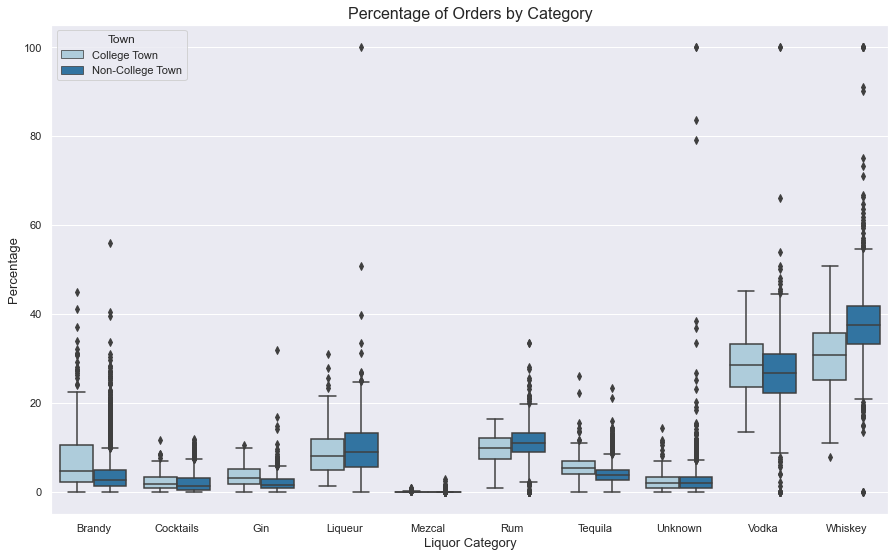

In [162]:
#create boxplot
plt.figure(figsize=(15,9))
sns.boxplot(x="GenCategory", y="value", hue='Town', data=storecat, palette = 'Paired')
plt.xlabel('Liquor Category', fontsize=13)
plt.ylabel('Percentage', fontsize=13)
plt.title('Percentage of Orders by Category', fontsize=16)

#### Run T-tests with p-value threshold of 0.05

In [70]:
#run t-test for brandy; reject null
stats.ttest_ind(colstorecat['Brandy'], noncolstorecat['Brandy'])

Ttest_indResult(statistic=9.732922915513521, pvalue=5.903721019469899e-22)

In [71]:
#run t-test for cocktails; fail to reject null
stats.ttest_ind(colstorecat['Cocktails'], noncolstorecat['Cocktails'])

Ttest_indResult(statistic=1.486040956579941, pvalue=0.13740907552367787)

In [72]:
#run t-test for gin; reject null
stats.ttest_ind(colstorecat['Gin'], noncolstorecat['Gin'])

Ttest_indResult(statistic=11.131881811801943, pvalue=4.712126294094562e-28)

In [73]:
#run t-test for liqueurs; fail to reject null
stats.ttest_ind(colstorecat['Liqueur'], noncolstorecat['Liqueur'])

Ttest_indResult(statistic=-1.9407795396719387, pvalue=0.05241038614329469)

In [74]:
#run t-test for mezcal; fail to reject null
stats.ttest_ind(colstorecat['Mezcal'], noncolstorecat['Mezcal'])

Ttest_indResult(statistic=1.8018250783500291, pvalue=0.07170739632718214)

In [75]:
#run t-test for rum; reject null
stats.ttest_ind(colstorecat['Rum'], noncolstorecat['Rum'])

Ttest_indResult(statistic=-5.085861939825882, pvalue=3.963574234205989e-07)

In [76]:
#run t-test for tequila; reject null
stats.ttest_ind(colstorecat['Tequila'], noncolstorecat['Tequila'])

Ttest_indResult(statistic=10.522825641127637, pvalue=2.6144827888749867e-25)

In [77]:
#run t-test for unknown; fail to reject null
stats.ttest_ind(colstorecat['Unknown'], noncolstorecat['Unknown'])

Ttest_indResult(statistic=-0.9343368960919667, pvalue=0.3502308891673709)

In [78]:
#run t-test for vodka; reject null
stats.ttest_ind(colstorecat['Vodka'], noncolstorecat['Vodka'])

Ttest_indResult(statistic=3.299102173059823, pvalue=0.000985143236913867)

In [79]:
#run t-test for whiskey; reject null
stats.ttest_ind(colstorecat['Whiskey'], noncolstorecat['Whiskey'])

Ttest_indResult(statistic=-10.997296703624642, pvalue=1.955841966760105e-27)

#### Product Seasonality

In [80]:
#create df for college towns of just date and general category
collegecattime = collegedf[['Date','GenCategory']]

In [81]:
#group df by date and category and get a count for each kind of alcohol purchased that month
cct_plot = collegecattime.groupby([pd.Grouper(key='Date', freq='1M'), pd.Grouper('GenCategory')]).size().unstack()

In [82]:
cct_plot.head()

GenCategory,Brandy,Cocktails,Gin,Liqueur,Mezcal,Rum,Tequila,Unknown,Vodka,Whiskey
Date,,,,,,,,,,
2018-01-31,1737,489,1080,3127,11,2439,1152,291,6275,7195
2018-02-28,1570,465,905,2273,13,2118,1029,250,5216,5810
2018-03-31,1597,507,929,2511,14,2140,1162,274,5389,5969
2018-04-30,1810,568,1045,2554,16,2244,1358,351,5741,6338
2018-05-31,1881,737,1234,2698,15,2485,1536,416,6211,6503


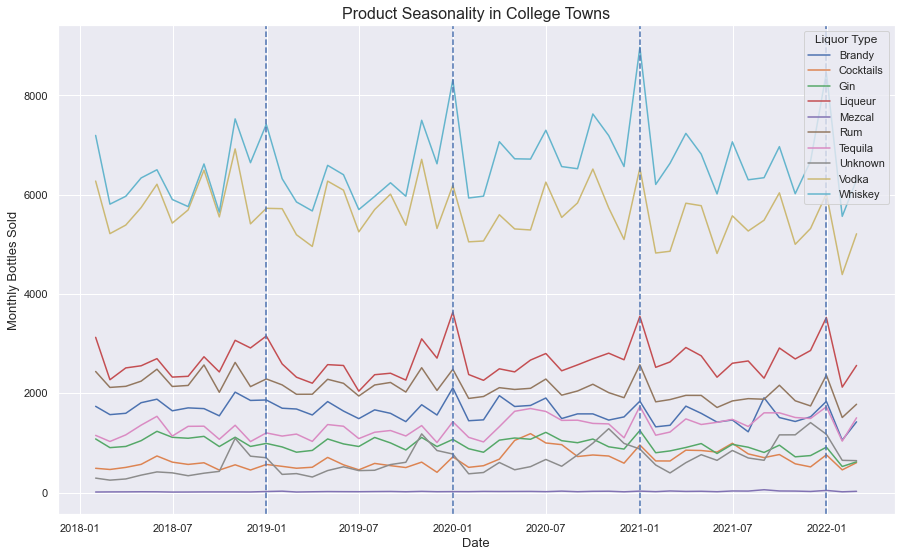

In [281]:
#create plot over time of product seasonality
plt.figure(figsize=(15,9))
plt.plot(cct_plot)
plt.title('Product Seasonality in College Towns', fontsize=16)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Monthly Bottles Sold', fontsize=13)
plt.legend(title='Liquor Type', labels=['Brandy','Cocktails','Gin','Liqueur','Mezcal','Rum','Tequila','Unknown','Vodka','Whiskey'])

#add vertical lines for Dec 31st every year
for i in range(2018,2022):
    plt.axvline(dt.datetime(i,12,31),linestyle='--')

In [84]:
#create df for non-college towns of just date and general category
noncollegecattime = noncollegedf[['Date','GenCategory']]

In [85]:
#group df by date and category and get a count for each kind of alcohol purchased that month
ncct_plot = noncollegecattime.groupby([pd.Grouper(key='Date', freq='1M'), pd.Grouper('GenCategory')]).size().unstack()

In [86]:
ncct_plot.head()

GenCategory,Brandy,Cocktails,Gin,Liqueur,Mezcal,Rum,Tequila,Unknown,Vodka,Whiskey
Date,,,,,,,,,,
2018-01-31,8995,3927,4762,23683,45,18905,7309,2088,41786,55766
2018-02-28,8271,3213,4352,18892,54,16447,6676,1590,37155,49494
2018-03-31,8391,4185,4897,22097,47,19022,7885,1826,43097,55246
2018-04-30,9163,4977,5176,20862,66,18167,8144,2462,42318,54589
2018-05-31,9116,6600,6498,24033,86,22342,10124,2692,52092,62091


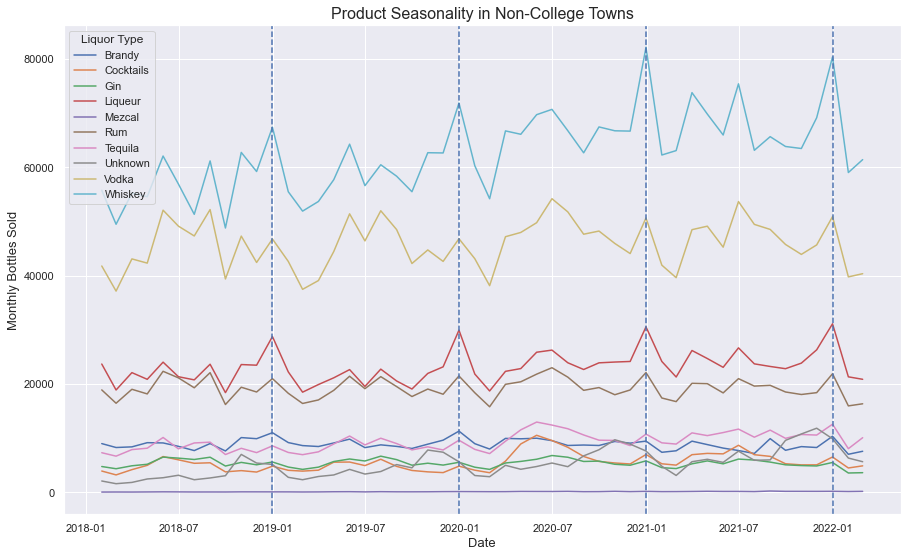

In [282]:
#create plot over time of product seasonality
plt.figure(figsize=(15,9))
plt.plot(ncct_plot)
plt.title('Product Seasonality in Non-College Towns', fontsize=16)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Monthly Bottles Sold', fontsize=13)
plt.legend(title='Liquor Type', labels=['Brandy','Cocktails','Gin','Liqueur','Mezcal','Rum','Tequila','Unknown','Vodka','Whiskey'])

#add vertical lines for Dec 31st every year
for i in range(2018,2022):
    plt.axvline(dt.datetime(i,12,31),linestyle='--')

In [88]:
#create vodka df
vodkadf = pd.concat([cct_plot['Vodka'],ncct_plot['Vodka']],axis=1,join='inner')

In [89]:
#rename columns
vodkadf.set_axis(['College Town','Non-College Town'],axis=1, inplace=True)

In [90]:
#get count of college town stores
colstorecount = len(storezipdf[storezipdf['ZipCode'].isin(college_zips)])

In [91]:
#get count of non-college town stores
noncolstorecount = len(storezipdf[~storezipdf['ZipCode'].isin(college_zips)])

In [92]:
#normalize by number of stores
vodkadf['College Town'] = vodkadf['College Town'] / colstorecount

In [93]:
#normalize by number of stores
vodkadf['Non-College Town'] = vodkadf['Non-College Town'] / noncolstorecount

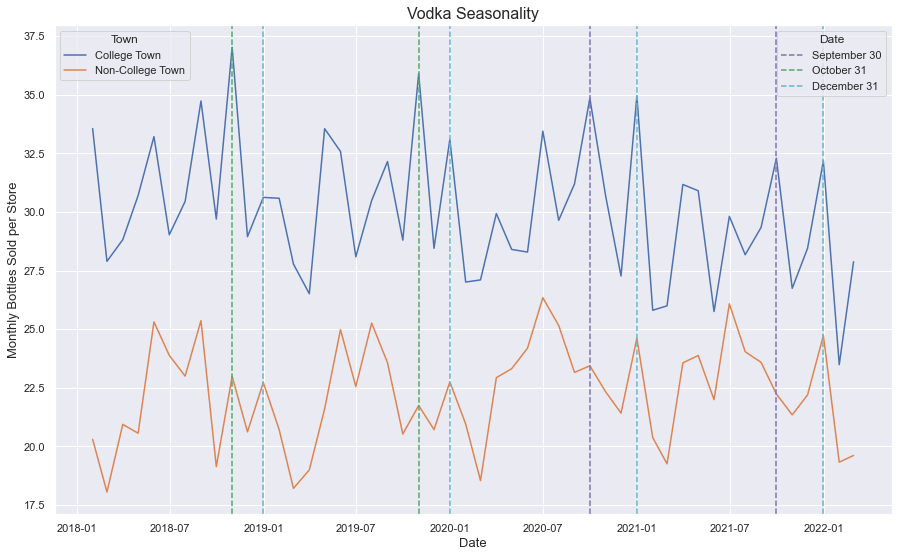

In [311]:
#create plot over time for vodka
plt.figure(figsize=(15,9))
plt.plot(vodkadf)
plt.title('Vodka Seasonality', fontsize=16)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Monthly Bottles Sold per Store', fontsize=13)
leg = plt.legend(title='Town', labels=['College Town','Non-College Town'])
ax = plt.gca().add_artist(leg)

#add vertical lines for Dec 31st every year
for i in range(2018,2022):
    dec = plt.axvline(dt.datetime(i,12,31),color='c',linestyle='--', label='December 31')

#add vertical lines for years with Sept spike
for i in range(2020,2022):
    sept = plt.axvline(dt.datetime(i,9,30),color='m',linestyle='--', label='September 30')

#add vertical lines for years with Oct spike
for i in range(2018,2020):
    octo = plt.axvline(dt.datetime(i,10,31),color='g',linestyle='--', label='October 31')
    
plt.legend(title='Date', handles=[sept, octo, dec], loc='upper right')

In [95]:
#create whiskey df
whiskeydf = pd.concat([cct_plot['Whiskey'],ncct_plot['Whiskey']],axis=1,join='inner')

In [96]:
#rename columns
whiskeydf.set_axis(['College Town','Non-College Town'],axis=1, inplace=True)

In [97]:
#normalize by number of stores
whiskeydf['College Town'] = whiskeydf['College Town'] / colstorecount

In [98]:
#normalize by number of stores
whiskeydf['Non-College Town'] = whiskeydf['Non-College Town'] / noncolstorecount

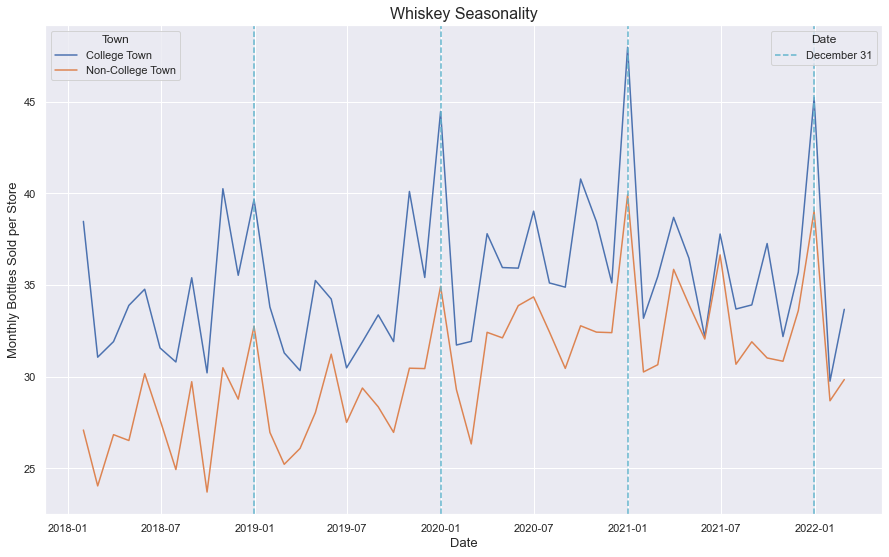

In [296]:
#create plot over time for whiskey
plt.figure(figsize=(15,9))
plt.plot(whiskeydf)
plt.title('Whiskey Seasonality',fontsize=16)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Monthly Bottles Sold per Store', fontsize=13)
leg = plt.legend(title='Town', labels=['College Town','Non-College Town'])
ax = plt.gca().add_artist(leg)

#add vertical lines for Dec 31st every year
for i in range(2018,2022):
    dec = plt.axvline(dt.datetime(i,12,31),color='c',linestyle='--', label='December 31')
    
plt.legend(title='Date', handles=[dec], loc='upper right')

In [100]:
#create brandy df
brandydf = pd.concat([cct_plot['Brandy'],ncct_plot['Brandy']],axis=1,join='inner')

In [101]:
#rename columns
brandydf.set_axis(['College Town','Non-College Town'],axis=1, inplace=True)

In [102]:
#normalize by number of stores
brandydf['College Town'] = brandydf['College Town'] / colstorecount

In [103]:
#normalize by number of stores
brandydf['Non-College Town'] = brandydf['Non-College Town'] / noncolstorecount

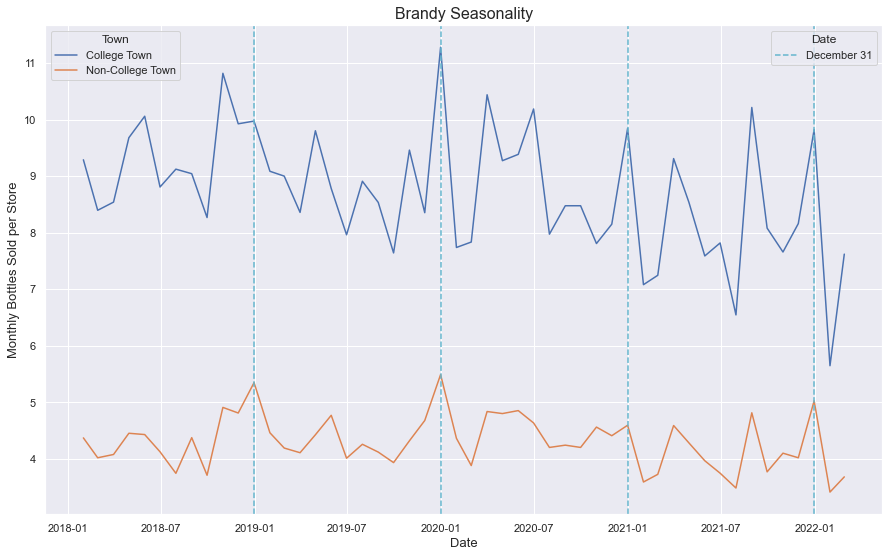

In [297]:
#create plot over time for brandy
plt.figure(figsize=(15,9))
plt.plot(brandydf)
plt.title('Brandy Seasonality', fontsize=16)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Monthly Bottles Sold per Store', fontsize=13)
leg = plt.legend(title='Town', labels=['College Town','Non-College Town'])
ax = plt.gca().add_artist(leg)

#add vertical lines for Dec 31st every year
for i in range(2018,2022):
    dec = plt.axvline(dt.datetime(i,12,31),color='c',linestyle='--', label='December 31')

plt.legend(title='Date', handles=[dec], loc='upper right')

In [105]:
#create cocktails df
cocktailsdf = pd.concat([cct_plot['Cocktails'],ncct_plot['Cocktails']],axis=1,join='inner')

In [106]:
#rename columns
cocktailsdf.set_axis(['College Town','Non-College Town'],axis=1, inplace=True)

In [107]:
#normalize by number of stores
cocktailsdf['College Town'] = cocktailsdf['College Town'] / colstorecount

In [108]:
#normalize by number of stores
cocktailsdf['Non-College Town'] = cocktailsdf['Non-College Town'] / noncolstorecount

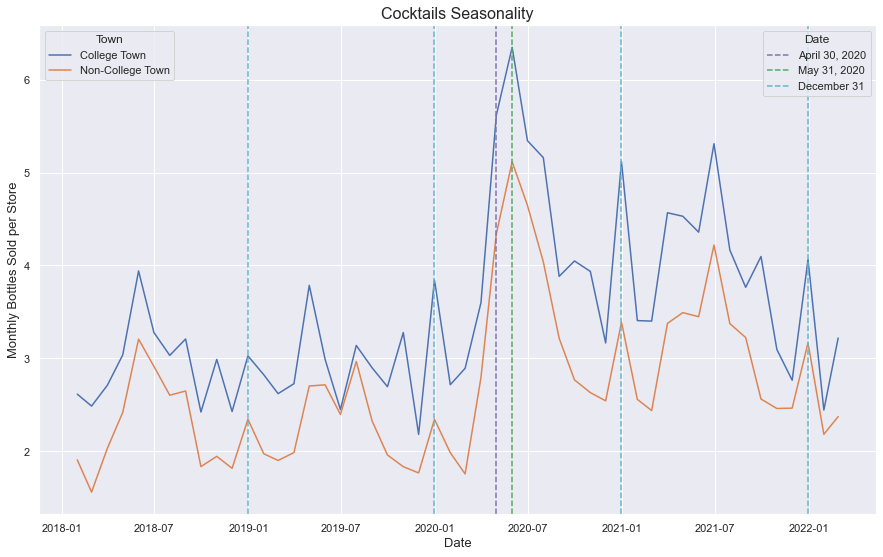

In [312]:
#create plot over time for cocktails
plt.figure(figsize=(15,9))
plt.plot(cocktailsdf)
plt.title('Cocktails Seasonality', fontsize=16)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Monthly Bottles Sold per Store', fontsize=13)
leg = plt.legend(title='Town', labels=['College Town','Non-College Town'])
ax = plt.gca().add_artist(leg)

#add vertical lines for Dec 31st every year
for i in range(2018,2022):
    dec = plt.axvline(dt.datetime(i,12,31),color='c',linestyle='--', label='December 31')

apr = plt.axvline(dt.datetime(2020,4,30),color='m',linestyle='--', label='April 30, 2020')

may = plt.axvline(dt.datetime(2020,5,31),color='g',linestyle='--', label='May 31, 2020')
    
plt.legend(title='Date', handles=[apr, may, dec], loc='upper right')

In [110]:
#create gin df
gindf = pd.concat([cct_plot['Gin'],ncct_plot['Gin']],axis=1,join='inner')

In [111]:
#rename columns
gindf.set_axis(['College Town','Non-College Town'],axis=1, inplace=True)

In [112]:
#normalize by number of stores
gindf['College Town'] = gindf['College Town'] / colstorecount

In [113]:
#normalize by number of stores
gindf['Non-College Town'] = gindf['Non-College Town'] / noncolstorecount

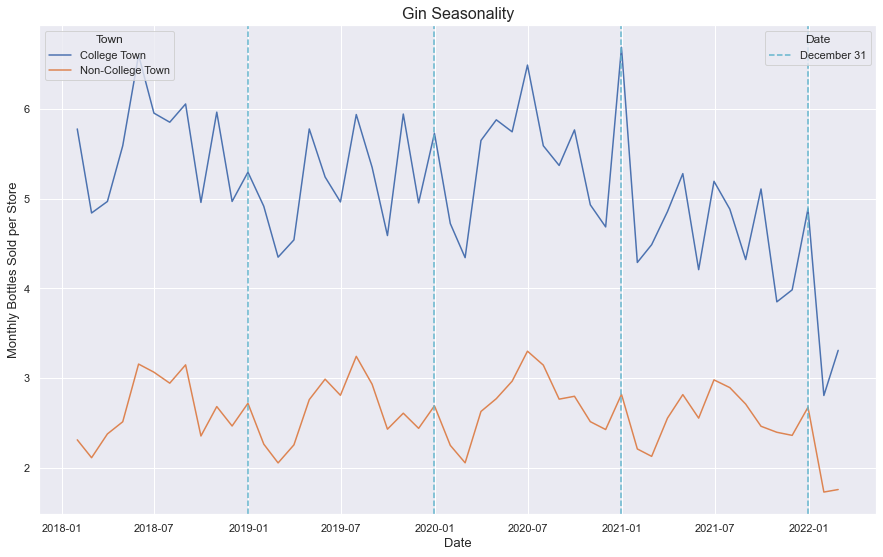

In [303]:
#create plot over time for gin
plt.figure(figsize=(15,9))
plt.plot(gindf)
plt.title('Gin Seasonality', fontsize=16)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Monthly Bottles Sold per Store', fontsize=13)
leg = plt.legend(title='Town', labels=['College Town','Non-College Town'], loc='upper left')
ax = plt.gca().add_artist(leg)

#add vertical lines for Dec 31st every year
for i in range(2018,2022):
    dec = plt.axvline(dt.datetime(i,12,31),color='c',linestyle='--', label='December 31')

plt.legend(title='Date', handles=[dec], loc='upper right')

In [115]:
#create liqueur df
liqueurdf = pd.concat([cct_plot['Liqueur'],ncct_plot['Liqueur']],axis=1,join='inner')

In [116]:
#rename columns
liqueurdf.set_axis(['College Town','Non-College Town'],axis=1, inplace=True)

In [117]:
#normalize by number of stores
liqueurdf['College Town'] = liqueurdf['College Town'] / colstorecount

In [118]:
#normalize by number of stores
liqueurdf['Non-College Town'] = liqueurdf['Non-College Town'] / noncolstorecount

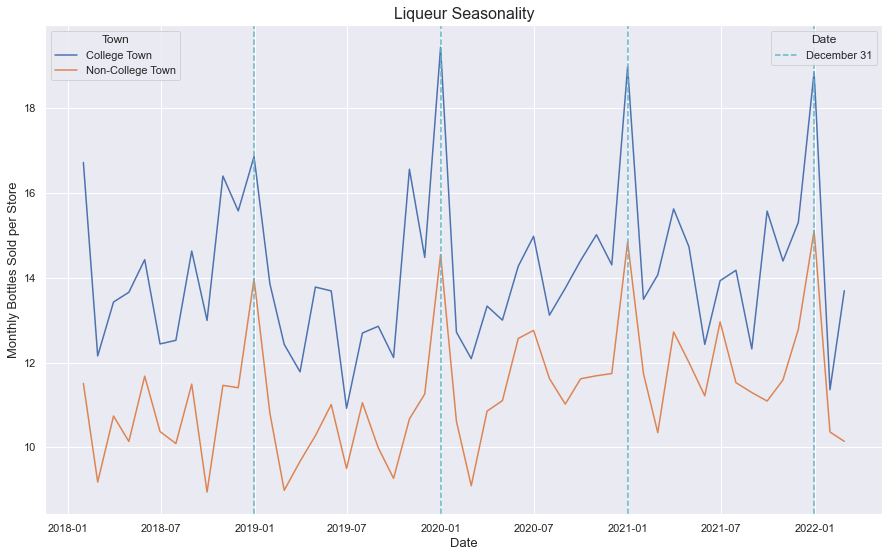

In [304]:
#create plot over time for liqueur
plt.figure(figsize=(15,9))
plt.plot(liqueurdf)
plt.title('Liqueur Seasonality', fontsize=16)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Monthly Bottles Sold per Store', fontsize=13)
leg = plt.legend(title='Town', labels=['College Town','Non-College Town'])
ax = plt.gca().add_artist(leg)

#add vertical lines for Dec 31st every year
for i in range(2018,2022):
    dec = plt.axvline(dt.datetime(i,12,31),color='c',linestyle='--', label='December 31')

plt.legend(title='Date', handles=[dec], loc='upper right')

In [120]:
#create mezcal df
mezcaldf = pd.concat([cct_plot['Mezcal'],ncct_plot['Mezcal']],axis=1,join='inner')

In [121]:
#rename columns
mezcaldf.set_axis(['College Town','Non-College Town'],axis=1, inplace=True)

In [122]:
#normalize by number of stores
mezcaldf['College Town'] = mezcaldf['College Town'] / colstorecount

In [123]:
#normalize by number of stores
mezcaldf['Non-College Town'] = mezcaldf['Non-College Town'] / noncolstorecount

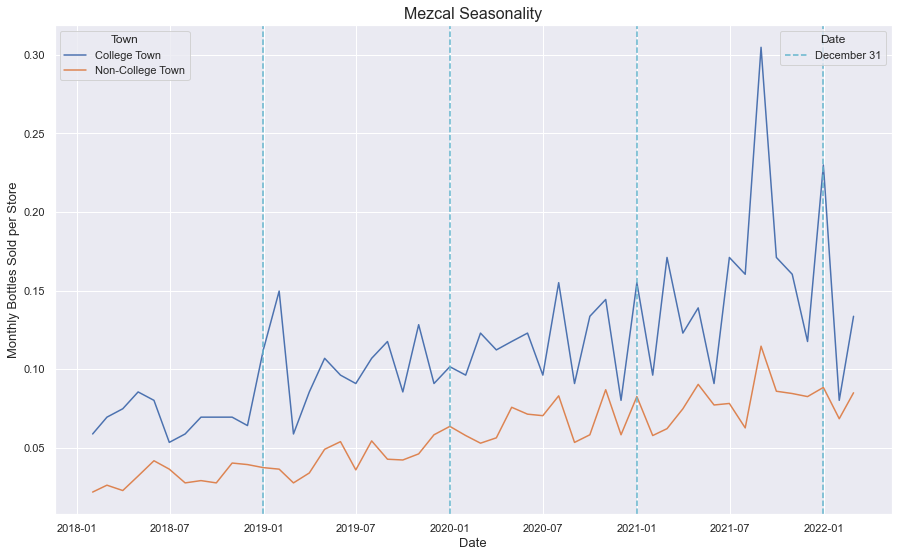

In [305]:
#create plot over time for mezcal
plt.figure(figsize=(15,9))
plt.plot(mezcaldf)
plt.title('Mezcal Seasonality', fontsize=16)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Monthly Bottles Sold per Store', fontsize=13)
leg = plt.legend(title='Town', labels=['College Town','Non-College Town'])
ax = plt.gca().add_artist(leg)

#add vertical lines for Dec 31st every year
for i in range(2018,2022):
    dec = plt.axvline(dt.datetime(i,12,31),color='c',linestyle='--', label='December 31')

plt.legend(title='Date', handles=[dec], loc='upper right')

In [125]:
#create rum df
rumdf = pd.concat([cct_plot['Rum'],ncct_plot['Rum']],axis=1,join='inner')

In [126]:
#rename columns
rumdf.set_axis(['College Town','Non-College Town'],axis=1, inplace=True)

In [127]:
#normalize by number of stores
rumdf['College Town'] = rumdf['College Town'] / colstorecount

In [128]:
#normalize by number of stores
rumdf['Non-College Town'] = rumdf['Non-College Town'] / noncolstorecount

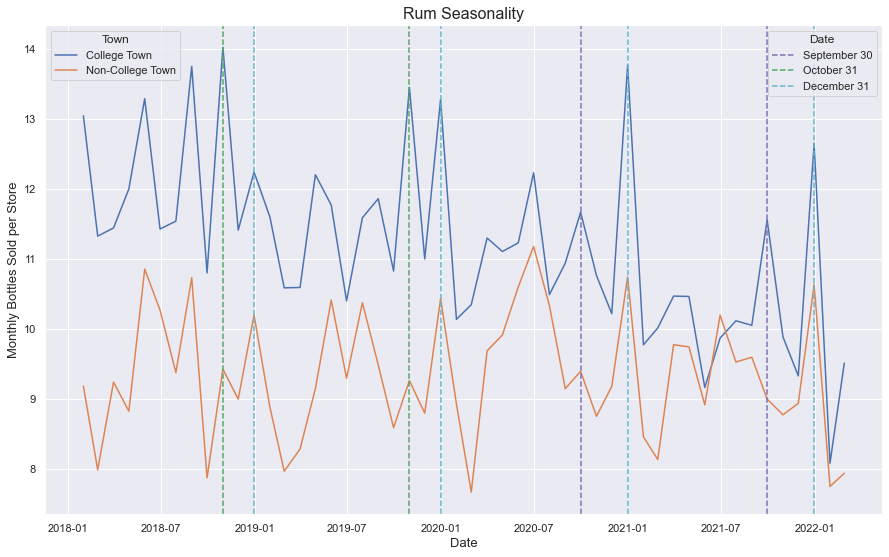

In [313]:
#create plot over time for rum
plt.figure(figsize=(15,9))
plt.plot(rumdf)
plt.title('Rum Seasonality', fontsize=16)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Monthly Bottles Sold per Store', fontsize=13)
leg = plt.legend(title='Town', labels=['College Town','Non-College Town'])
ax = plt.gca().add_artist(leg)

#add vertical lines for Dec 31st every year
for i in range(2018,2022):
    dec = plt.axvline(dt.datetime(i,12,31),color='c',linestyle='--', label='December 31')

for i in range(2020,2022):
    sept = plt.axvline(dt.datetime(i,9,30),color='m',linestyle='--', label='September 30')

for i in range(2018,2020):
    octo = plt.axvline(dt.datetime(i,10,31),color='g',linestyle='--', label='October 31')

plt.legend(title='Date', handles=[sept, octo, dec], loc='upper right')

In [130]:
#create tequila df
tequiladf = pd.concat([cct_plot['Tequila'],ncct_plot['Tequila']],axis=1,join='inner')

In [131]:
#rename columns
tequiladf.set_axis(['College Town','Non-College Town'],axis=1, inplace=True)

In [132]:
#normalize by number of stores
tequiladf['College Town'] = tequiladf['College Town'] / colstorecount

In [133]:
#normalize by number of stores
tequiladf['Non-College Town'] = tequiladf['Non-College Town'] / noncolstorecount

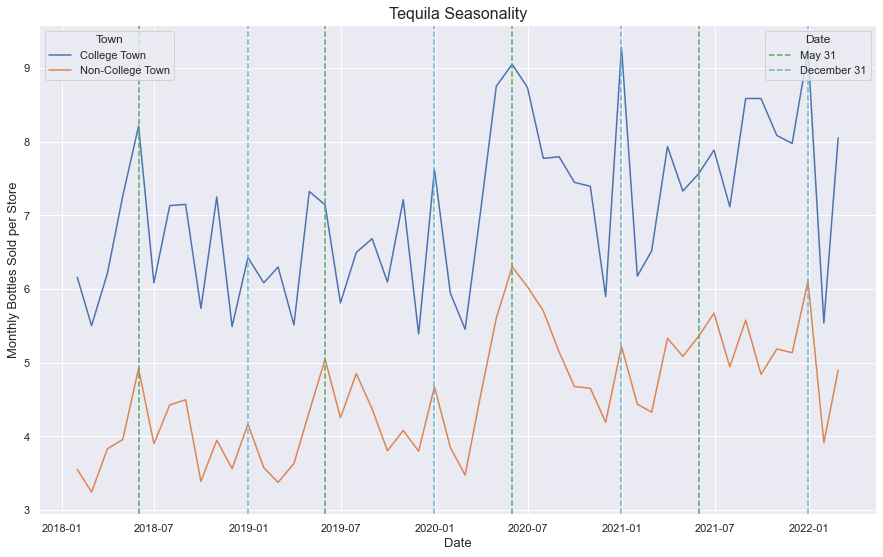

In [315]:
#create plot over time for tequila
plt.figure(figsize=(15,9))
plt.plot(tequiladf)
plt.title('Tequila Seasonality', fontsize=16)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Monthly Bottles Sold per Store', fontsize=13)
leg = plt.legend(title='Town', labels=['College Town','Non-College Town'])
ax = plt.gca().add_artist(leg)

#add vertical lines for Dec 31st every year
for i in range(2018,2022):
    dec = plt.axvline(dt.datetime(i,12,31),color='c',linestyle='--', label='December 31')

for i in range(2018,2022):
    may = plt.axvline(dt.datetime(i,5,31),color='g',linestyle='--', label='May 31')

plt.legend(title='Date', handles=[may, dec], loc='upper right')

In [135]:
#create unknown df
unknowndf = pd.concat([cct_plot['Unknown'],ncct_plot['Unknown']],axis=1,join='inner')

In [136]:
#rename columns
unknowndf.set_axis(['College Town','Non-College Town'],axis=1, inplace=True)

In [137]:
#normalize by number of stores
unknowndf['College Town'] = unknowndf['College Town'] / colstorecount

In [138]:
#normalize by number of stores
unknowndf['Non-College Town'] = unknowndf['Non-College Town'] / noncolstorecount

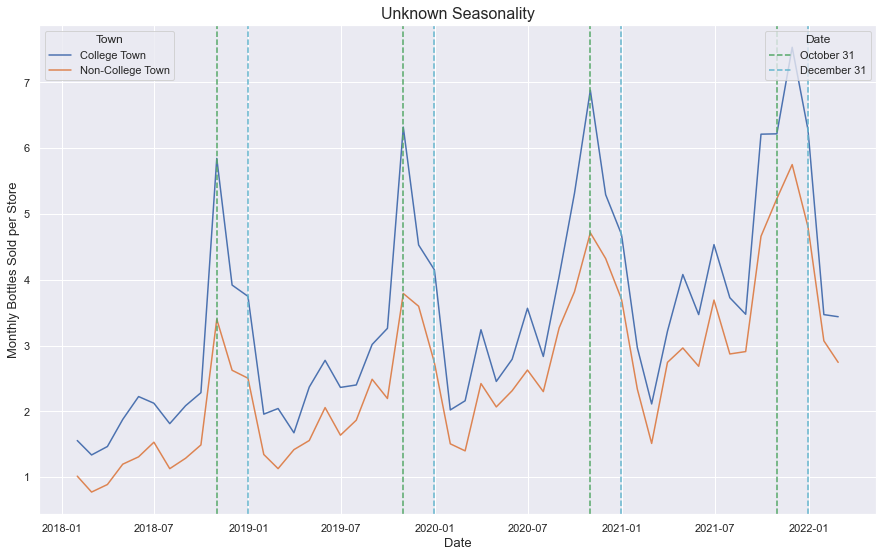

In [317]:
#create plot over time for unknown
plt.figure(figsize=(15,9))
plt.plot(unknowndf)
plt.title('Unknown Seasonality', fontsize=16)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Monthly Bottles Sold per Store', fontsize=13)
leg = plt.legend(title='Town', labels=['College Town','Non-College Town'])
ax = plt.gca().add_artist(leg)

#add vertical lines for Dec 31st every year
for i in range(2018,2022):
    dec = plt.axvline(dt.datetime(i,12,31),color='c',linestyle='--', label='December 31')

for i in range(2018,2022):
    octo = plt.axvline(dt.datetime(i,10,31),color='g',linestyle='--', label='October 31')

plt.legend(title='Date', handles=[octo, dec], loc='upper right')

### Price Distribution

In [140]:
#create college prices df
college_prices = collegedf[['BottlesSold','Sale']]

In [141]:
#create new column bottle price that gives the price of each individual bottle
college_prices['BottlePrice'] = college_prices['Sale'] / college_prices['BottlesSold']

C:\Users\dougl\AppData\Local\Temp/ipykernel_24536/2230616652.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  college_prices['BottlePrice'] = college_prices['Sale'] / college_prices['BottlesSold']


In [142]:
college_prices

,BottlesSold,Sale,BottlePrice
3,1,13.59,13.59
11,3,84.03,28.01
14,3,29.13,9.71
15,6,64.62,10.77
21,12,163.08,13.59
...,...,...,...
10375546,12,252.00,21.00
10375565,6,99.00,16.50
10375626,6,64.80,10.80
10375695,12,117.00,9.75


In [143]:
#get summary stats on bottle prices
college_prices['BottlePrice'].describe()

count    1.110207e+06
mean     1.625037e+01
std      1.444597e+01
min      0.000000e+00
25%      8.270000e+00
50%      1.275000e+01
75%      2.025000e+01
max      3.148410e+03
Name: BottlePrice, dtype: float64

<AxesSubplot:>

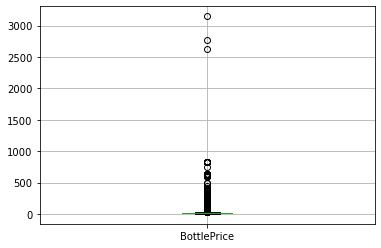

In [144]:
college_prices.boxplot(column=['BottlePrice'])

In [145]:
#create non-college prices df
noncollege_prices = noncollegedf[['BottlesSold','Sale']]

In [146]:
#create new column bottle price that gives the price of each individual bottle
noncollege_prices['BottlePrice'] = noncollege_prices['Sale'] / noncollege_prices['BottlesSold']

C:\Users\dougl\AppData\Local\Temp/ipykernel_24536/3264533683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  noncollege_prices['BottlePrice'] = noncollege_prices['Sale'] / noncollege_prices['BottlesSold']


In [147]:
#remove row where bottles sold = 0
noncollege_prices = noncollege_prices[~(noncollege_prices['BottlesSold'] == 0)]

In [148]:
noncollege_prices

,BottlesSold,Sale,BottlePrice
0,2,44.98,22.49
1,1,44.30,44.30
2,6,68.40,11.40
4,2,13.98,6.99
5,12,60.72,5.06
...,...,...,...
10375839,1,27.00,27.00
10375840,60,1935.00,32.25
10375841,1,19.44,19.44
10375842,12,117.00,9.75


In [149]:
#get summary stats on bottle prices
noncollege_prices['BottlePrice'].describe()

count    9.265636e+06
mean     1.607806e+01
std      1.486081e+01
min      0.000000e+00
25%      8.580000e+00
50%      1.299000e+01
75%      1.950000e+01
max      3.148410e+03
Name: BottlePrice, dtype: float64

<AxesSubplot:>

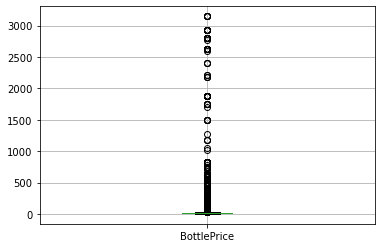

In [150]:
noncollege_prices.boxplot(column=['BottlePrice'])

##### Violin Plot of Bottle Prices under $100

In [230]:
#create dataframe of bottle prices <= 100 and column for type of town

#select college town rows where price <= 100
colfiltered = college_prices[college_prices['BottlePrice'] <= 100]

In [231]:
#select just bottle price column
pricetown = colfiltered[['BottlePrice']]

In [232]:
#add new column that specifies the kind of town
pricetown['Town'] = 'College Town'

C:\Users\dougl\AppData\Local\Temp/ipykernel_24536/2186365748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pricetown['Town'] = 'College Town'


In [233]:
#select non-college town rows where price <= 100
noncolfiltered = noncollege_prices[noncollege_prices['BottlePrice'] <= 100]

In [234]:
#select just bottle price column
noncolfiltered = noncolfiltered[['BottlePrice']]

In [235]:
#add new column that specifies the kind of town
noncolfiltered['Town'] = 'Non-College Town'

In [236]:
#combine the two tables together
pricetown = pd.concat([pricetown,noncolfiltered])

In [237]:
pricetown

,BottlePrice,Town
3,13.59,College Town
11,28.01,College Town
14,9.71,College Town
15,10.77,College Town
21,13.59,College Town
...,...,...
10375839,27.00,Non-College Town
10375840,32.25,Non-College Town
10375841,19.44,Non-College Town
10375842,9.75,Non-College Town


Text(0, 0.5, 'Bottle Price')

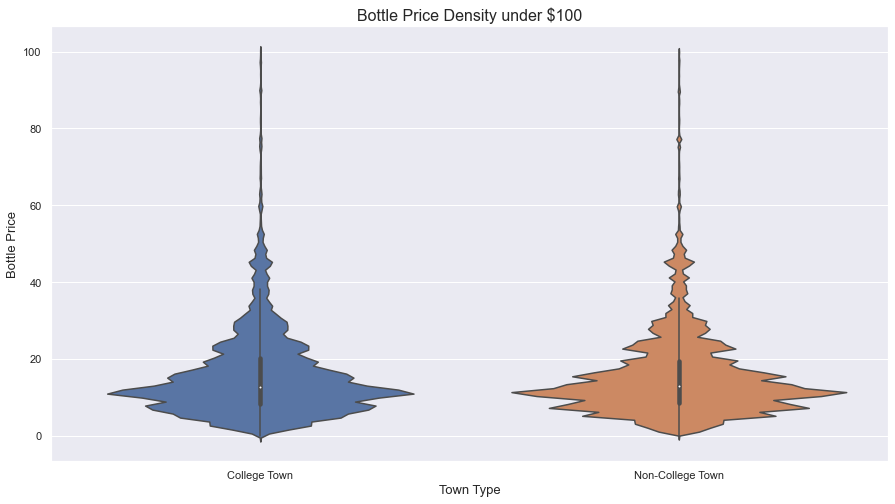

In [224]:
#create violin plot of bottle price by town type
sns.set(rc = {'figure.figsize':(15,8)})
sns.violinplot(x='Town', y='BottlePrice',data=pricetown)
plt.title('Bottle Price Density under $100', fontsize=16)
plt.xlabel('Town Type', fontsize=13)
plt.ylabel('Bottle Price', fontsize=13)

Text(0, 0.5, 'Density')

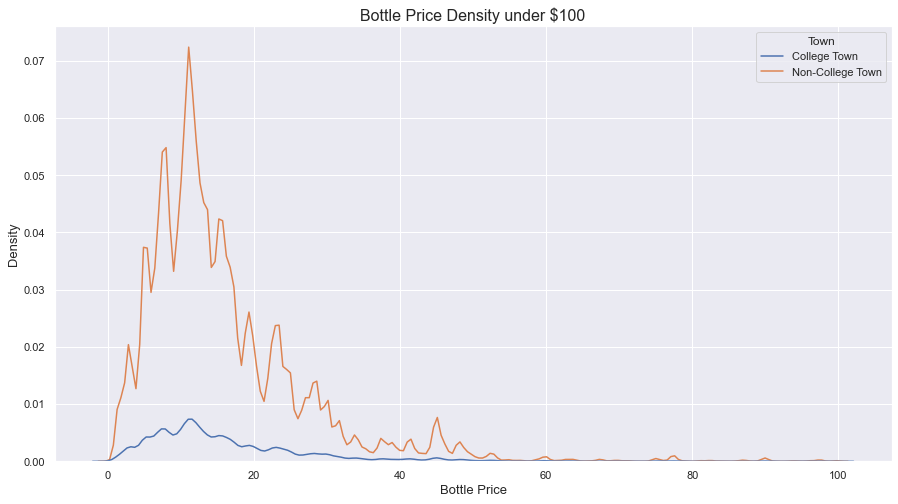

In [238]:
#create kde plot of bottle price by town type
sns.set(rc = {'figure.figsize':(15,8)})
sns.kdeplot(x='BottlePrice',data=pricetown, hue='Town')
plt.title('Bottle Price Density under $100', fontsize=16)
plt.xlabel('Bottle Price', fontsize=13)
plt.ylabel('Density', fontsize=13)

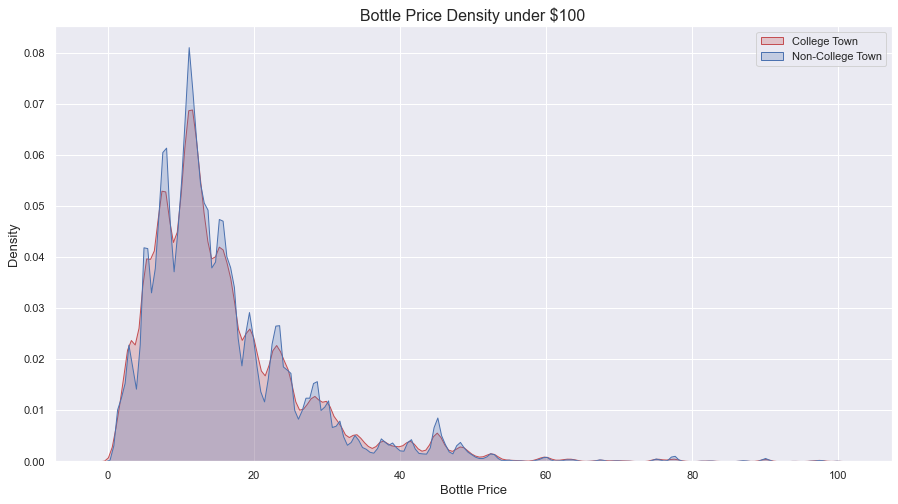

In [239]:
# plotting both distibutions on the same figure
fig = sns.kdeplot(colfiltered['BottlePrice'], shade=True, color="r", label='College Town')
fig = sns.kdeplot(noncolfiltered['BottlePrice'], shade=True, color="b", label='Non-College Town')
plt.title('Bottle Price Density under $100', fontsize=16)
plt.xlabel('Bottle Price', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.legend()
plt.show()

##### Violin Plot of Prices over $1,000

In [240]:
#create dataframe of bottle prices >= 1000 and column for type of town

#select college town rows where price >= 1000
colfiltered = college_prices[college_prices['BottlePrice'] >= 1000]

In [241]:
#select just bottle price column
pricetown1000 = colfiltered[['BottlePrice']]

In [242]:
#add new column that specifies the kind of town
pricetown1000['Town'] = 'College Town'

C:\Users\dougl\AppData\Local\Temp/ipykernel_24536/2643274823.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pricetown1000['Town'] = 'College Town'


In [243]:
#select non-college town rows where price >= 1000
noncolfiltered = noncollege_prices[noncollege_prices['BottlePrice'] >= 1000]

In [244]:
#select just bottle price column
noncolfiltered = noncolfiltered[['BottlePrice']]

In [245]:
#add new column that specifies the kind of town
noncolfiltered['Town'] = 'Non-College Town'

In [246]:
#combine the two tables together
pricetown1000 = pd.concat([pricetown1000,noncolfiltered])

Text(0, 0.5, 'Bottle Price')

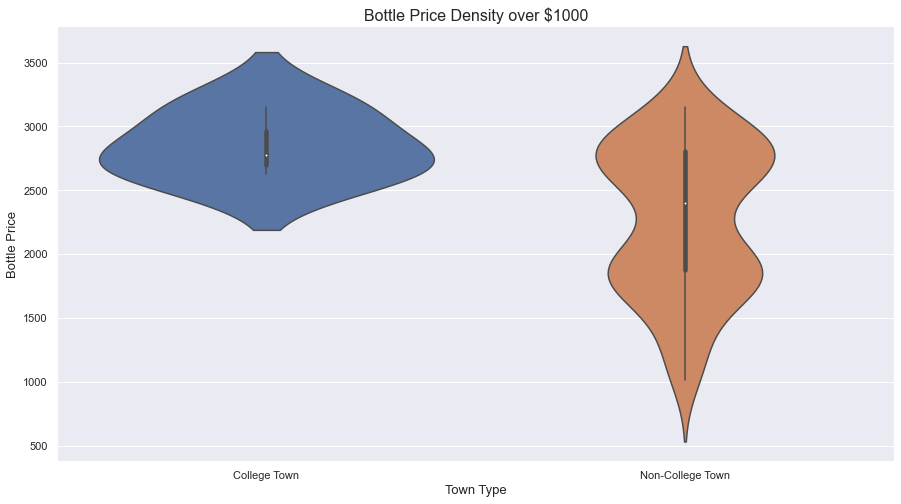

In [247]:
#create violin plot of bottle price by town type
sns.set(rc = {'figure.figsize':(15,8)})
sns.violinplot(x='Town', y='BottlePrice', data=pricetown1000)
plt.title('Bottle Price Density over $1000', fontsize=16)
plt.xlabel('Town Type', fontsize=13)
plt.ylabel('Bottle Price', fontsize=13)

#### Price Seasonality

In [183]:
colpricetime = collegedf[['Date','Sale','BottlesSold']]

In [184]:
#calculate individual bottle price
colpricetime['BottlePrice'] = colpricetime['Sale'] / colpricetime['BottlesSold']

C:\Users\dougl\AppData\Local\Temp/ipykernel_24536/3830282319.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colpricetime['BottlePrice'] = colpricetime['Sale'] / colpricetime['BottlesSold']


In [185]:
#group df by date and get average bottle price per month
cpt_plot = colpricetime[['Date','BottlePrice']].groupby(pd.Grouper(key='Date', freq='1M')).mean()

Text(0, 0.5, 'Average Price ($)')

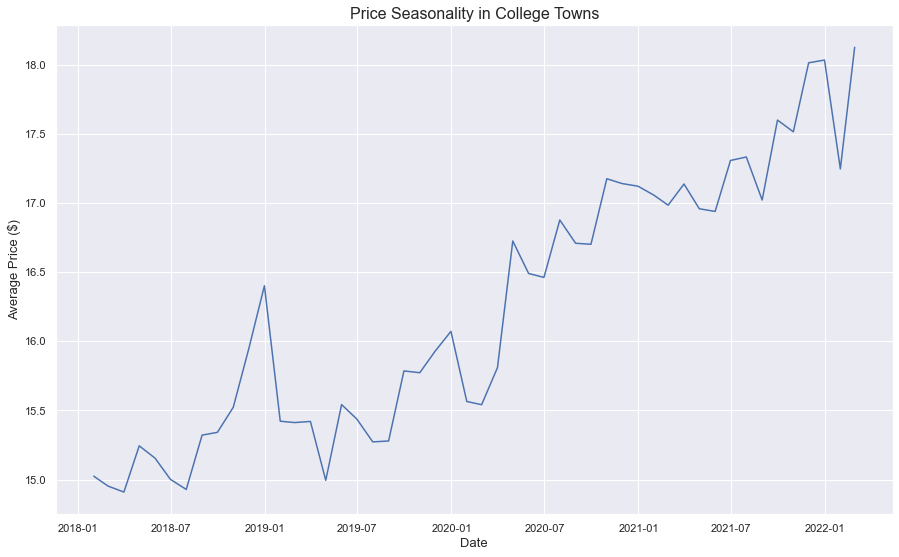

In [248]:
#create plot over time of price seasonality in college towns
plt.figure(figsize=(15,9))
plt.plot(cpt_plot)
plt.title('Price Seasonality in College Towns', fontsize=16)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Average Price ($)', fontsize=13)

In [187]:
ncolpricetime = noncollegedf[['Date','Sale','BottlesSold']]

In [188]:
#calculate individual bottle price
ncolpricetime['BottlePrice'] = ncolpricetime['Sale'] / ncolpricetime['BottlesSold']

C:\Users\dougl\AppData\Local\Temp/ipykernel_24536/3309493731.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ncolpricetime['BottlePrice'] = ncolpricetime['Sale'] / ncolpricetime['BottlesSold']


In [189]:
#group df by date and get average sale amount per month
ncpt_plot = ncolpricetime[['Date','BottlePrice']].groupby(pd.Grouper(key='Date', freq='1M')).mean()

Text(0, 0.5, 'Average Price ($)')

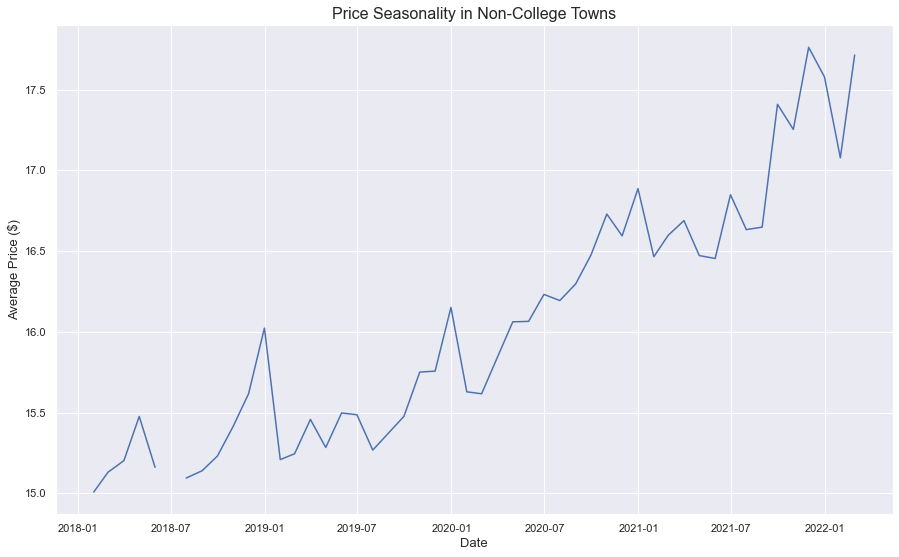

In [249]:
#create plot over time of price seasonality in non-college towns
plt.figure(figsize=(15,9))
plt.plot(ncpt_plot)
plt.title('Price Seasonality in Non-College Towns', fontsize=16)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Average Price ($)', fontsize=13)

In [191]:
#merge the two monthly prices
pricetime_plot = pd.merge(cpt_plot, ncpt_plot, on='Date', how='left')

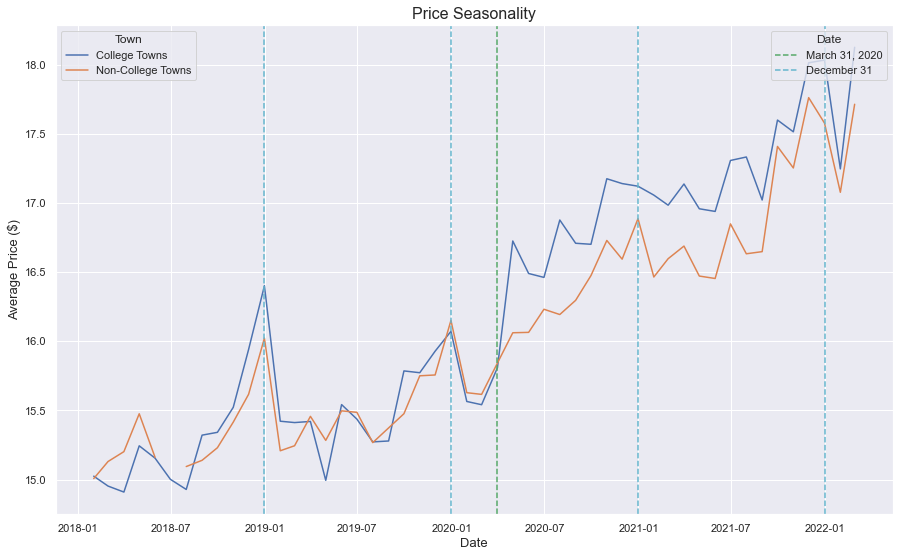

In [319]:
#create plot over time of price seasonality
plt.figure(figsize=(15,9))
plt.plot(pricetime_plot)
plt.title('Price Seasonality', fontsize=16)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Average Price ($)', fontsize=13)
leg = plt.legend(title='Town',labels=['College Towns','Non-College Towns'])
ax = plt.gca().add_artist(leg)

for i in range(2018,2022):
    dec = plt.axvline(dt.datetime(i,12,31),color='c',linestyle='--', label='December 31')

mar = plt.axvline(dt.datetime(2020,3,31),color='g',linestyle='--', label='March 31, 2020')

plt.legend(title='Date', handles=[mar, dec], loc='upper right')

### Volume Distribution

In [193]:
#create table of college town volume of bottles sold
college_vol = pd.merge(collegedf[['ItemNumber','GenCategory']], productsdf[['ItemNumber','BottleVolume(ml)']], on='ItemNumber', how='left')

In [194]:
college_vol

,ItemNumber,GenCategory,BottleVolume(ml)
0,26821,Whiskey,500
1,27464,Whiskey,750
2,82612,Liqueur,750
3,35948,Vodka,1750
4,43285,Rum,750
...,...,...,...
1110202,19112,Whiskey,750
1110203,87018,Whiskey,750
1110204,35918,Vodka,1750
1110205,73456,Liqueur,750


In [195]:
college_vol['BottleVolume(ml)'].describe()

count    1.110207e+06
mean     8.526337e+02
std      4.916947e+02
min      0.000000e+00
25%      6.000000e+02
50%      7.500000e+02
75%      1.000000e+03
max      6.000000e+03
Name: BottleVolume(ml), dtype: float64

Text(0, 0.5, 'Bottle Volume (ml)')

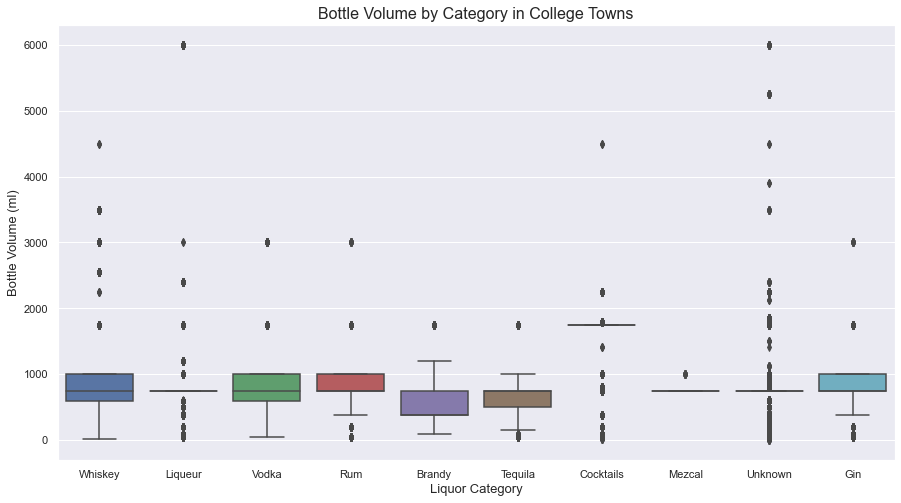

In [252]:
sns.boxplot(x='GenCategory', y='BottleVolume(ml)', data=college_vol)
plt.title('Bottle Volume by Category in College Towns', fontsize=16)
plt.xlabel('Liquor Category', fontsize=13)
plt.ylabel('Bottle Volume (ml)', fontsize=13)

In [197]:
#create table of non-college town volume of bottles sold
noncollege_vol = pd.merge(noncollegedf[['ItemNumber','GenCategory']], productsdf[['ItemNumber','BottleVolume(ml)']], on='ItemNumber', how='left')

In [198]:
noncollege_vol

,ItemNumber,GenCategory,BottleVolume(ml)
0,34117,Vodka,1000
1,65251,Liqueur,1200
2,37348,Vodka,1750
3,86833,Whiskey,500
4,35316,Vodka,750
...,...,...,...
9265632,43338,Rum,1750
9265633,87410,Tequila,1750
9265634,25608,Whiskey,1750
9265635,63321,Cocktails,375


In [199]:
noncollege_vol['BottleVolume(ml)'].describe()

count    9.265637e+06
mean     9.023430e+02
std      5.210499e+02
min      0.000000e+00
25%      7.500000e+02
50%      7.500000e+02
75%      1.000000e+03
max      6.000000e+03
Name: BottleVolume(ml), dtype: float64

Text(0, 0.5, 'Bottle Volume (ml)')

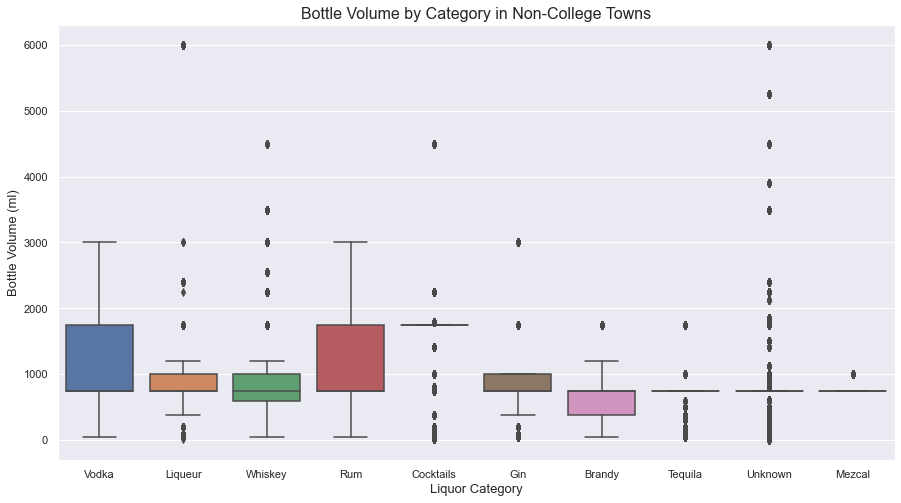

In [253]:
sns.boxplot(x='GenCategory', y='BottleVolume(ml)', data=noncollege_vol)
plt.title('Bottle Volume by Category in Non-College Towns', fontsize=16)
plt.xlabel('Liquor Category', fontsize=13)
plt.ylabel('Bottle Volume (ml)', fontsize=13)

In [201]:
#add town type to college vol df
college_vol['Town'] = 'College Town'

In [202]:
#add town type to non-college vol df
noncollege_vol['Town'] = 'Non-College Town'

In [203]:
#concat two df's
voldf = pd.concat([college_vol,noncollege_vol])

In [204]:
voldf

,ItemNumber,GenCategory,BottleVolume(ml),Town
0,26821,Whiskey,500,College Town
1,27464,Whiskey,750,College Town
2,82612,Liqueur,750,College Town
3,35948,Vodka,1750,College Town
4,43285,Rum,750,College Town
...,...,...,...,...
9265632,43338,Rum,1750,Non-College Town
9265633,87410,Tequila,1750,Non-College Town
9265634,25608,Whiskey,1750,Non-College Town
9265635,63321,Cocktails,375,Non-College Town


Text(0, 0.5, 'Bottle Volume (ml)')

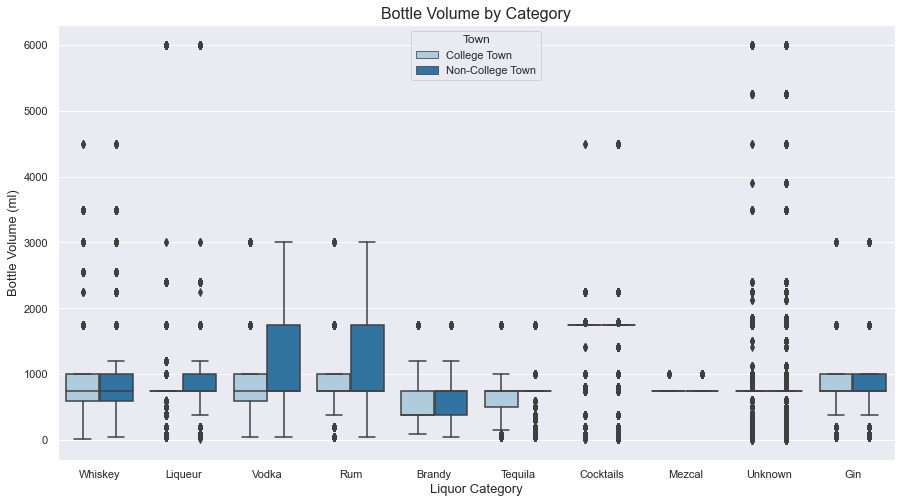

In [254]:
#create boxplot
sns.boxplot(x='GenCategory',y='BottleVolume(ml)',hue='Town',data=voldf, palette = 'Paired')
plt.title('Bottle Volume by Category', fontsize=16)
plt.xlabel('Liquor Category', fontsize=13)
plt.ylabel('Bottle Volume (ml)', fontsize=13)

#### Run t-tests with p-value of 0.05

In [206]:
#run t-test for whiskey; reject null
stats.ttest_ind(college_vol[college_vol['GenCategory'] == 'Whiskey']['BottleVolume(ml)'], noncollege_vol[noncollege_vol['GenCategory'] == 'Whiskey']['BottleVolume(ml)'])

Ttest_indResult(statistic=-41.5362773381549, pvalue=0.0)

In [207]:
#run t-test for liqueur; reject null
stats.ttest_ind(college_vol[college_vol['GenCategory'] == 'Liqueur']['BottleVolume(ml)'], noncollege_vol[noncollege_vol['GenCategory'] == 'Liqueur']['BottleVolume(ml)'])

Ttest_indResult(statistic=-9.563800745175406, pvalue=1.1369805544809312e-21)

In [208]:
#run t-test for vodka; reject null
stats.ttest_ind(college_vol[college_vol['GenCategory'] == 'Vodka']['BottleVolume(ml)'], noncollege_vol[noncollege_vol['GenCategory'] == 'Vodka']['BottleVolume(ml)'])

Ttest_indResult(statistic=-49.35507975829944, pvalue=0.0)

In [209]:
#run t-test for rum; reject null
stats.ttest_ind(college_vol[college_vol['GenCategory'] == 'Rum']['BottleVolume(ml)'], noncollege_vol[noncollege_vol['GenCategory'] == 'Rum']['BottleVolume(ml)'])

Ttest_indResult(statistic=-19.009819832865805, pvalue=1.4586085379510086e-80)

In [210]:
#run t-test for brandy; reject null
stats.ttest_ind(college_vol[college_vol['GenCategory'] == 'Brandy']['BottleVolume(ml)'], noncollege_vol[noncollege_vol['GenCategory'] == 'Brandy']['BottleVolume(ml)'])

Ttest_indResult(statistic=-52.90599653721787, pvalue=0.0)

In [211]:
#run t-test for tequila; reject null
stats.ttest_ind(college_vol[college_vol['GenCategory'] == 'Tequila']['BottleVolume(ml)'], noncollege_vol[noncollege_vol['GenCategory'] == 'Tequila']['BottleVolume(ml)'])

Ttest_indResult(statistic=-21.646178696865103, pvalue=7.320626998674093e-104)

In [212]:
#run t-test for cocktails; reject null
stats.ttest_ind(college_vol[college_vol['GenCategory'] == 'Cocktails']['BottleVolume(ml)'], noncollege_vol[noncollege_vol['GenCategory'] == 'Cocktails']['BottleVolume(ml)'])

Ttest_indResult(statistic=-31.585735633532526, pvalue=1.2933816976985445e-218)

In [213]:
#run t-test for mezcal; reject null
stats.ttest_ind(college_vol[college_vol['GenCategory'] == 'Mezcal']['BottleVolume(ml)'], noncollege_vol[noncollege_vol['GenCategory'] == 'Mezcal']['BottleVolume(ml)'])

Ttest_indResult(statistic=-2.4730543545627284, pvalue=0.0134202205566503)

In [214]:
#run t-test for unknown; reject null
stats.ttest_ind(college_vol[college_vol['GenCategory'] == 'Unknown']['BottleVolume(ml)'], noncollege_vol[noncollege_vol['GenCategory'] == 'Unknown']['BottleVolume(ml)'])

Ttest_indResult(statistic=3.724186645642297, pvalue=0.00019598242420228968)

In [215]:
#run t-test for gin; reject null
stats.ttest_ind(college_vol[college_vol['GenCategory'] == 'Gin']['BottleVolume(ml)'], noncollege_vol[noncollege_vol['GenCategory'] == 'Gin']['BottleVolume(ml)'])

Ttest_indResult(statistic=-26.691516941697596, pvalue=8.831517981858355e-157)